In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho do shapefile baseado no modelo
shapefile_path = r"..\..\Data\Processed\PT-FireSprd_v3.0\L2_FireBehavior\PT-FireSprd_v3.0_L2_short.csv"

# Ler o shapefile
df = pd.read_csv(shapefile_path)

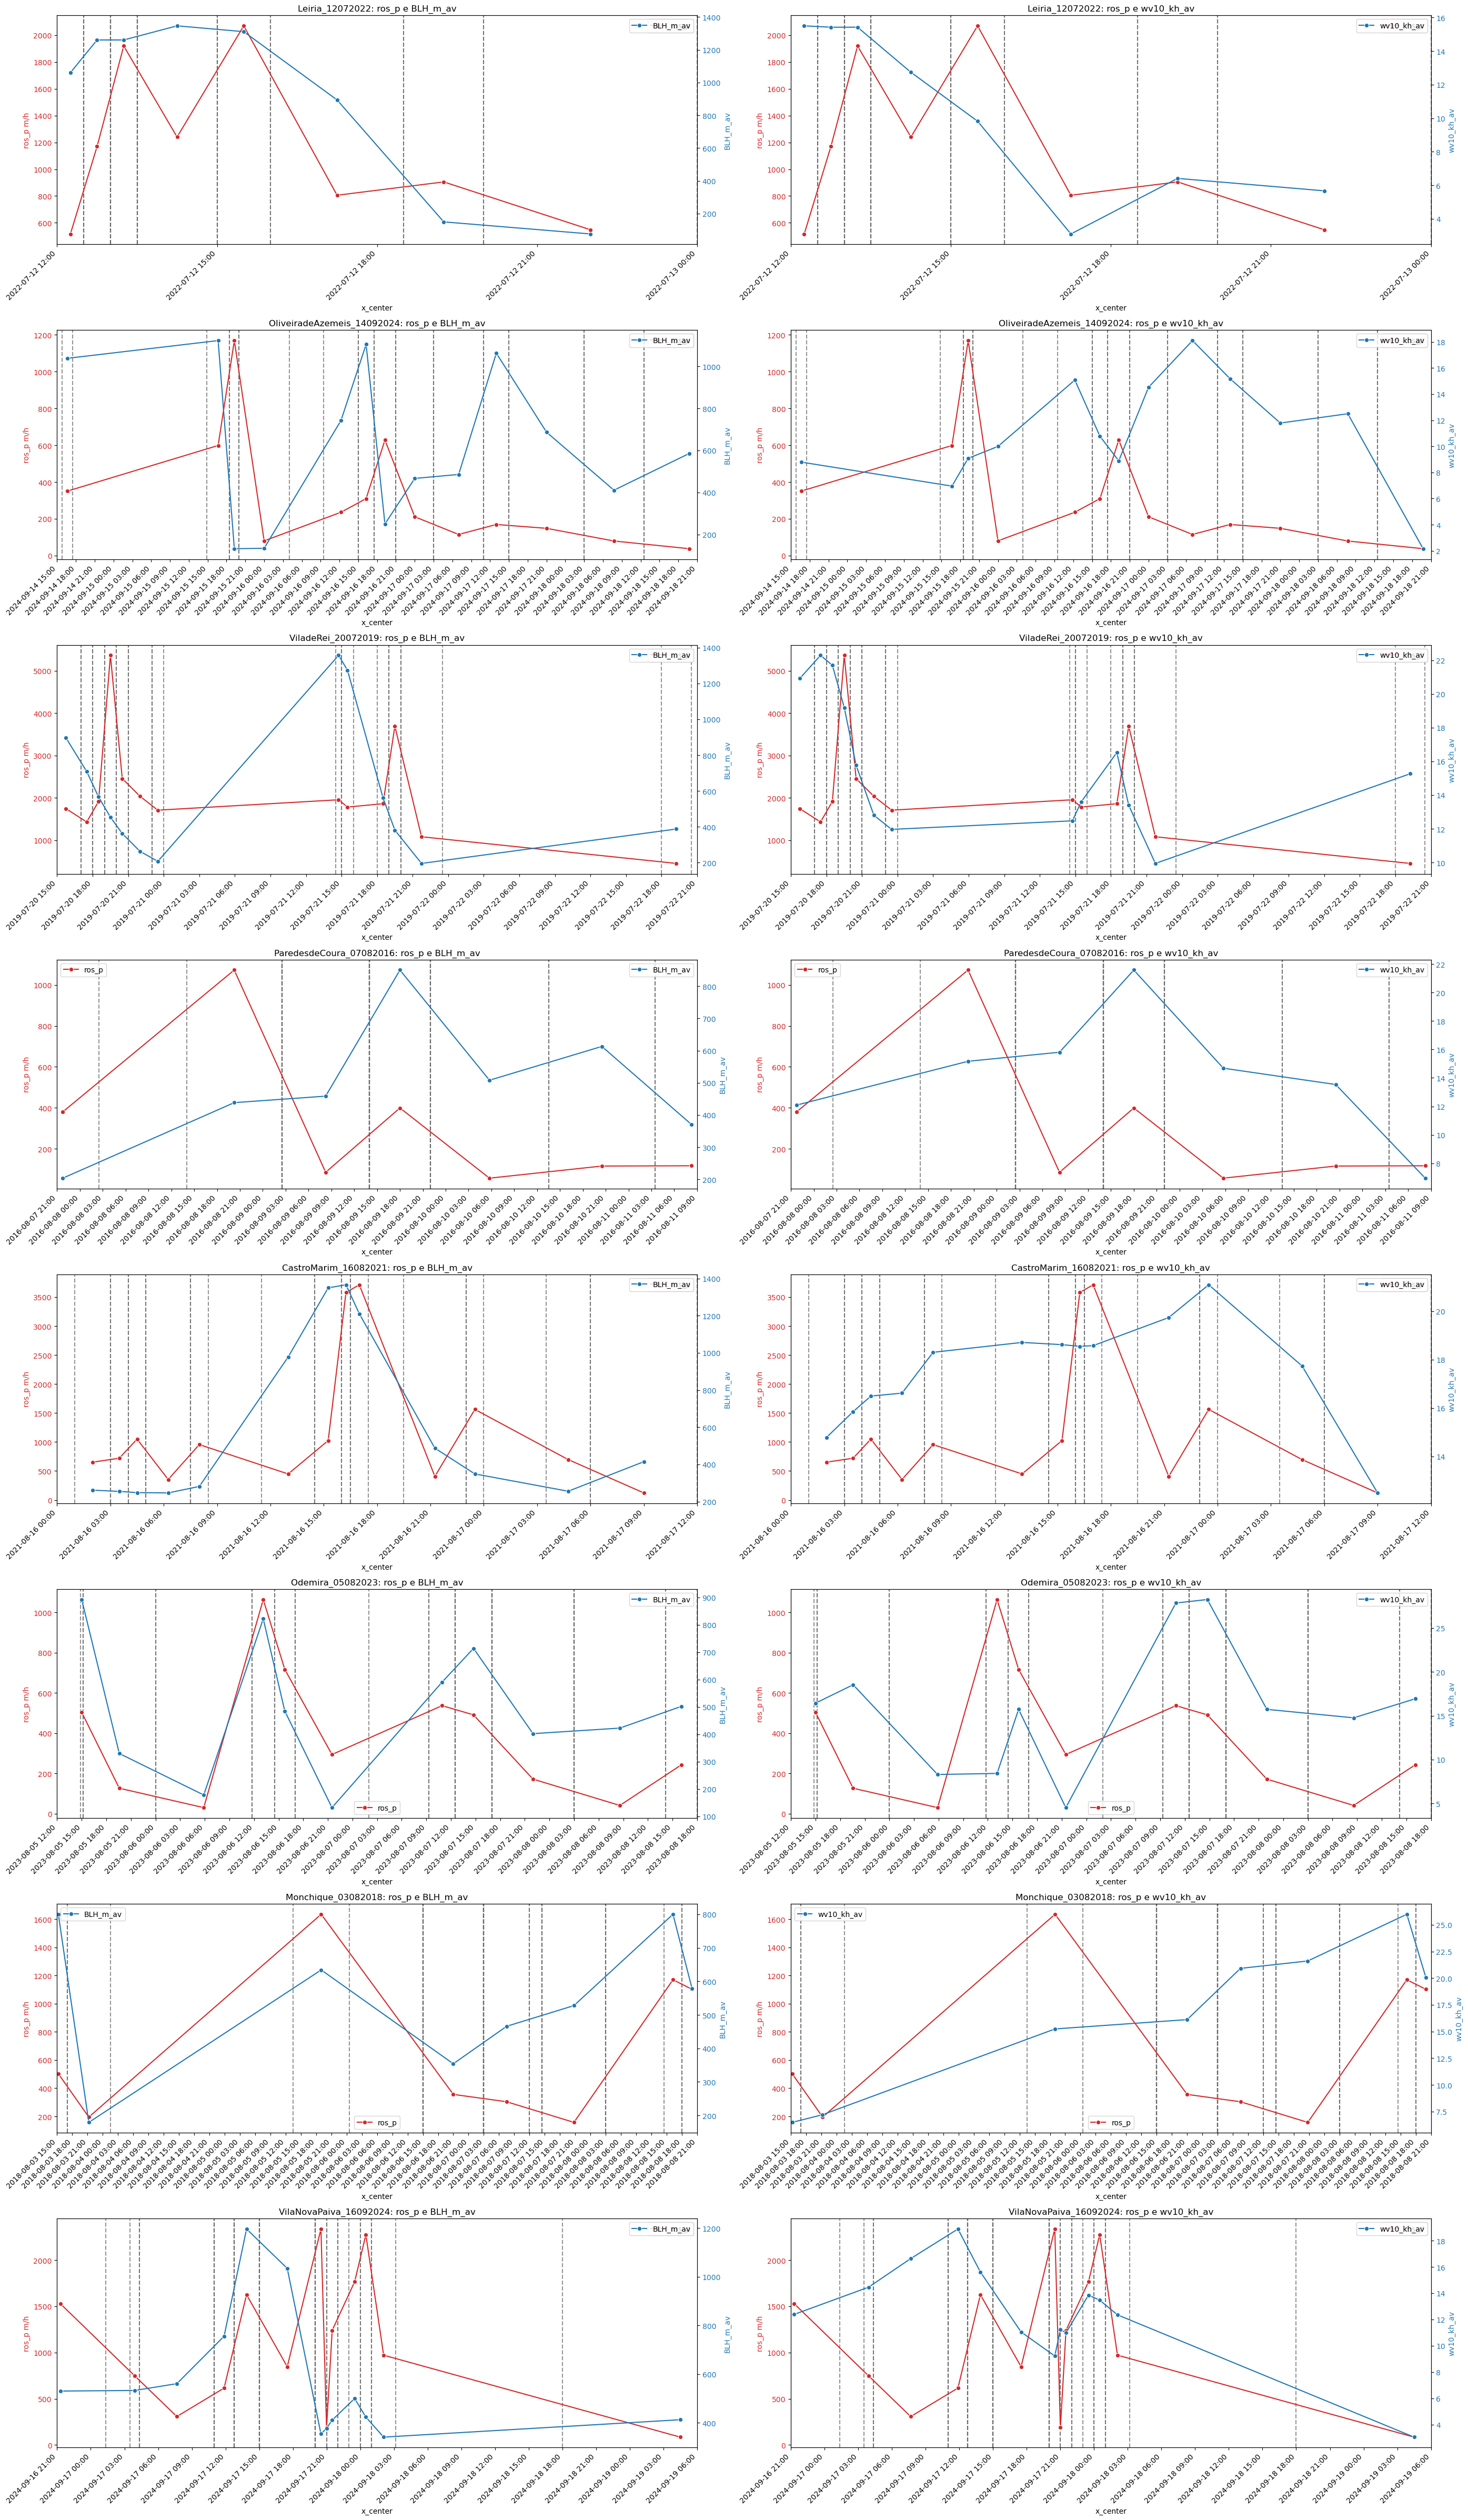

In [4]:
import matplotlib.dates as mdates

fid_list = [84,140,59,16,77,93,47,155]
sec_vars = ['BLH_m_av', 'wv10_kh_av']  # múltiplas variáveis secundárias
main_var = 'ros_p'

# Largura e altura por subplot
width_per_plot = 14
height_per_plot = 6

# Criar grid de subplots: linhas = FIDs, colunas = número de variáveis secundárias
fig, axes = plt.subplots(
    len(fid_list), 
    len(sec_vars), 
    figsize=(width_per_plot * len(sec_vars), height_per_plot * len(fid_list)), 
    sharex=False
)

# Se só houver 1 FID ou 1 coluna, garantir que axes seja sempre 2D
if len(fid_list) == 1 and len(sec_vars) == 1:
    axes = [[axes]]
elif len(fid_list) == 1:
    axes = [axes]
elif len(sec_vars) == 1:
    axes = [[ax] for ax in axes]

# Ajuste do layout para evitar "squish" horizontal
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, fid in enumerate(fid_list):
    df_fid = df[df['fid'] == fid].copy()
    df_fid['sdate'] = pd.to_datetime(df_fid['sdate'])
    df_fid['edate'] = pd.to_datetime(df_fid['edate'])
    df_fid['x_center'] = df_fid['sdate'] + (df_fid['edate'] - df_fid['sdate']) / 2
    df_fid = df_fid.sort_values('x_center')

    for j, sec_var in enumerate(sec_vars):
        ax = axes[i][j]

        # Linha principal (vermelha)
        sns.lineplot(
            x='x_center',
            y=main_var,
            data=df_fid,
            ax=ax,
            color='tab:red',
            marker='o',
            label=main_var,
            errorbar=None
        )
        ax.set_ylabel(f'{main_var} m/h', color='tab:red')
        ax.tick_params(axis='y', labelcolor='tab:red')

        # Linha secundária (azul)
        ax2 = ax.twinx()
        sns.lineplot(
            x='x_center',
            y=sec_var,
            data=df_fid,
            ax=ax2,
            color='tab:blue',
            marker='o',
            label=sec_var,
            errorbar=None
        )
        ax2.set_ylabel(sec_var, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        # Linhas verticais em sdate e edate
        for dt in pd.concat([df_fid['sdate'], df_fid['edate']]):
            ax.axvline(dt, color='dimgray', linestyle='--', alpha=0.7, zorder=0)

        # Ticks de 3h alinhados aos múltiplos de 3h
        min_center = df_fid['x_center'].min()
        max_center = df_fid['x_center'].max()

        start_hour = (min_center.hour // 3) * 3
        start_tick = min_center.replace(hour=start_hour, minute=0, second=0, microsecond=0)
        if start_tick == min_center:
            start_tick -= pd.Timedelta(hours=3)

        end_hour = ((max_center.hour // 3) + 1) * 3
        if end_hour >= 24:
            end_tick = (max_center + pd.Timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        else:
            end_tick = max_center.replace(hour=end_hour, minute=0, second=0, microsecond=0)

        ticks = pd.date_range(start=start_tick, end=end_tick, freq='3h')
        ax.set_xticks(ticks)
        ax.set_xlim(ticks.min(), ticks.max())
        labels = [dt.strftime('%Y-%m-%d %H:%M') for dt in ticks]
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # Título
        fname_unique = df_fid['fname'].unique()
        if len(fname_unique) == 1:
            ax.set_title(f"{fname_unique[0]}: {main_var} e {sec_var}")
        else:
            ax.set_title(f"FID {fid}: {main_var} e {sec_var}")

# Ajuste final
plt.tight_layout()
plt.show()
